# Basics of Text Mining

Requirement to upload before running:
- API_key.text: your OpenAI API key
- wharton_data.xlsx: Data contains post data
- stopwords.txt: stop words for preprocessing

1. Word frequency and word cloud
2. Sentiment
3. Topic models
4. Post Metric Prediction

In [173]:
! pip install lda
! pip install dexplot
! pip install jieba
! pip install stopwordsiso
! pip install snownlp
! pip install jiagu
! pip install pyltp
! pip install openai==0.28
! pip install transformers
! pip install -U text2vec
! pip install 'optimum[openvino]'
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
! pip install textblob
! pip install ace_tools

  Using cached pyltp-0.4.0.tar.gz (4.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyltp (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyltp
Failed to build pyltp
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pyltp)
Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('averaged_perceptron_tagger')
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation as LDA
import lda
import dexplot as dxp
import jieba
import jieba.posseg as pseg
import stopwordsiso
from stopwordsiso import stopwords
import re
import matplotlib
import matplotlib.font_manager as fm
from snownlp import SnowNLP
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import jiagu
import openai
import time
import os
from sklearn.metrics.pairwise import cosine_similarity
from text2vec import SentenceModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
# load stop words
with open("/content/drive/MyDrive/Marketing Analytics Course Preparation/Sichen/NYU Stern Social Media/Model Creation/data/stopwords.txt", "r", encoding="utf-8") as file:
    stop_words = set(file.read().splitlines())
# Print a sample of the stop words
print("Sample stop words:", list(stop_words)[:10])

Sample stop words: ['amidst', '紧接着', '哉', 'how', 'then', "shan't", '。', '“', '归', 'l']


# Data Cleaning

In [46]:
post_df = pd.read_excel("/content/drive/MyDrive/Marketing Analytics Course Preparation/Sichen/NYU Stern Social Media/Model Creation/data/wharton_data.xlsx")
post_df.columns = ["row_number", "post_date", "content", "like_count", "comments", "media_type", "image_url", "video_url", "article_url"]
post_df = post_df.dropna()
post_df.shape

(267, 9)

In [47]:
post_df.groupby("media_type")['like_count'].mean()

,like_count
media_type,
Article Link,54.400000
Image,42.539216
Text,29.512500
Video,158.262500


In [48]:
post_df.head()

,row_number,post_date,content,like_count,comments,media_type,image_url,video_url,article_url
0,1,"12/9/24, 11:01AM (EST)",What are the factors shaping the future of fin...,437,4,Video,No images,https://dms.licdn.com/playlist/vid/dynamic/D56...,https://www.linkedin.com/feed/hashtag/?keyword...
1,2,"1/22/25, 1:00PM (EST)",How can tax and spending reforms reduce the na...,13,0,Text,No images,No videos,https://www.linkedin.com/feed/hashtag/?keyword...
2,3,"1/17/25, 8:45AM (EST)","While leaders often succumb to ""not invented h...",34,0,Image,https://media.licdn.com/dms/image/v2/D4E10AQGn...,No videos,https://www.linkedin.com/feed/hashtag/?keyword...
3,4,"1/20/25, 9:00AM (EST)",Three professors weigh in on the impact of int...,3,0,Text,No images,No videos,https://www.linkedin.com/in/ACoAABbbHCIBpUmuGM...
4,5,"1/16/25, 3:21PM (EST)","While AI is transforming industries, its resou...",14,1,Text,No images,No videos,https://www.linkedin.com/feed/hashtag/?keyword...


In [58]:
# Remove stop words
post_df['content_processed'] = post_df['content'].apply(
    lambda x: " ".join(word for word in jiagu.seg(x) if word.lower() not in stop_words)
)

# Remove numbers and non-alphabetic characters
post_df['content_processed'] = post_df['content_processed'].apply(
    lambda x: " ".join(word for word in jiagu.seg(x) if word.isalpha())
)

In [50]:
post_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   row_number         267 non-null    int64 
 1   post_date          267 non-null    object
 2   content            267 non-null    object
 3   like_count         267 non-null    int64 
 4   comments           267 non-null    int64 
 5   media_type         267 non-null    object
 6   image_url          267 non-null    object
 7   video_url          267 non-null    object
 8   article_url        267 non-null    object
 9   content_processed  267 non-null    object
dtypes: int64(3), object(7)
memory usage: 21.0+ KB


In [51]:
post_df['content_processed'].head()

,content_processed
0,factors shaping future finance part interview ...
1,tax spending reforms reduce national debt boos...
2,leaders succumb invented NIH syndrome prioriti...
3,professors weigh impact interest rates inflati...
4,AI transforming industries resource demands ov...


In [52]:
post_df['media_type'].value_counts()

,count
media_type,
Image,102
Video,80
Text,80
Article Link,5


## Word frequency and word cloud

In [109]:
# store (account, data from account) pairs as a list
df_pairs = []
for account in post_df['media_type'].unique():
    df_pairs.append((t, post_df[post_df['media_type'] == account]))

In [110]:
def my_tokenizer_jieba(text):
    return [i.word for i in pseg.cut(text)] if text != None else []

def my_tokenizer_jiagu(text):
    return [i for i in jiagu.seg(text)] if text != None else []

In [111]:
tokens_lst = [(account, df['content_processed'].map(my_tokenizer_jiagu).sum()) for account, df in df_pairs]
counter_lst = [(account, Counter(token_lst)) for account, token_lst in tokens_lst]

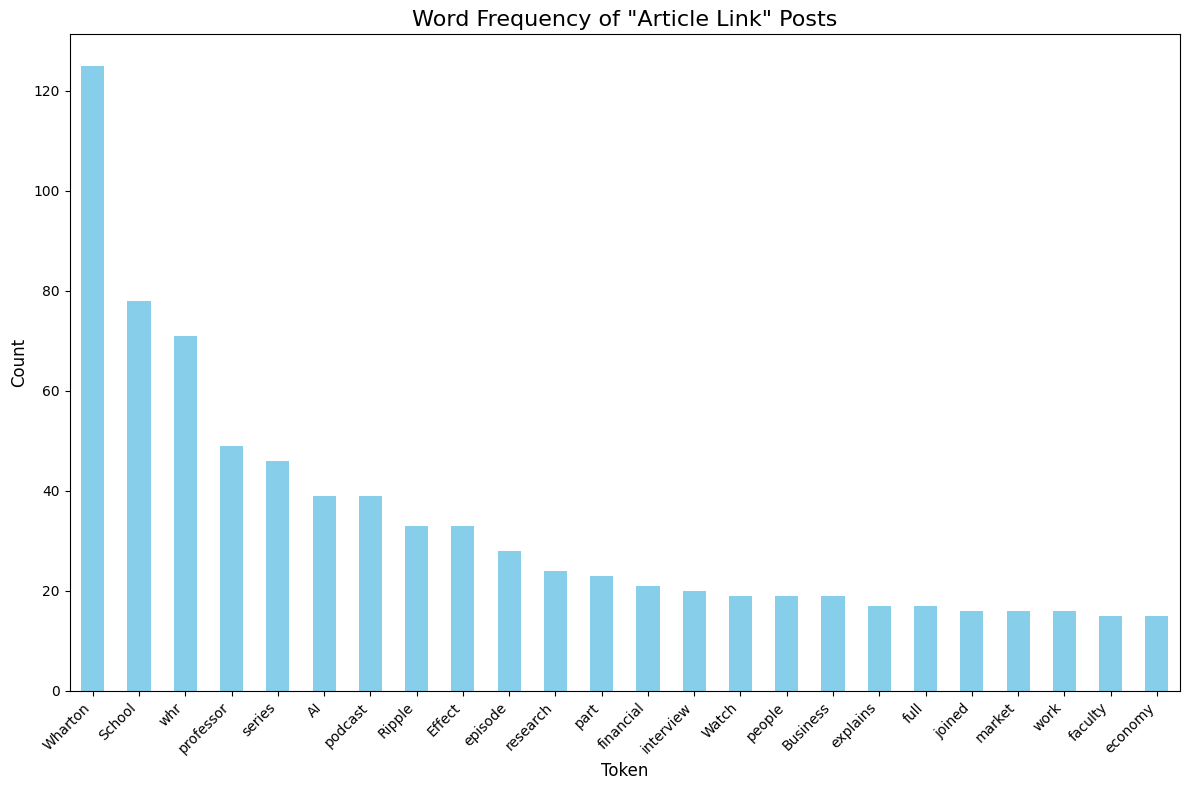

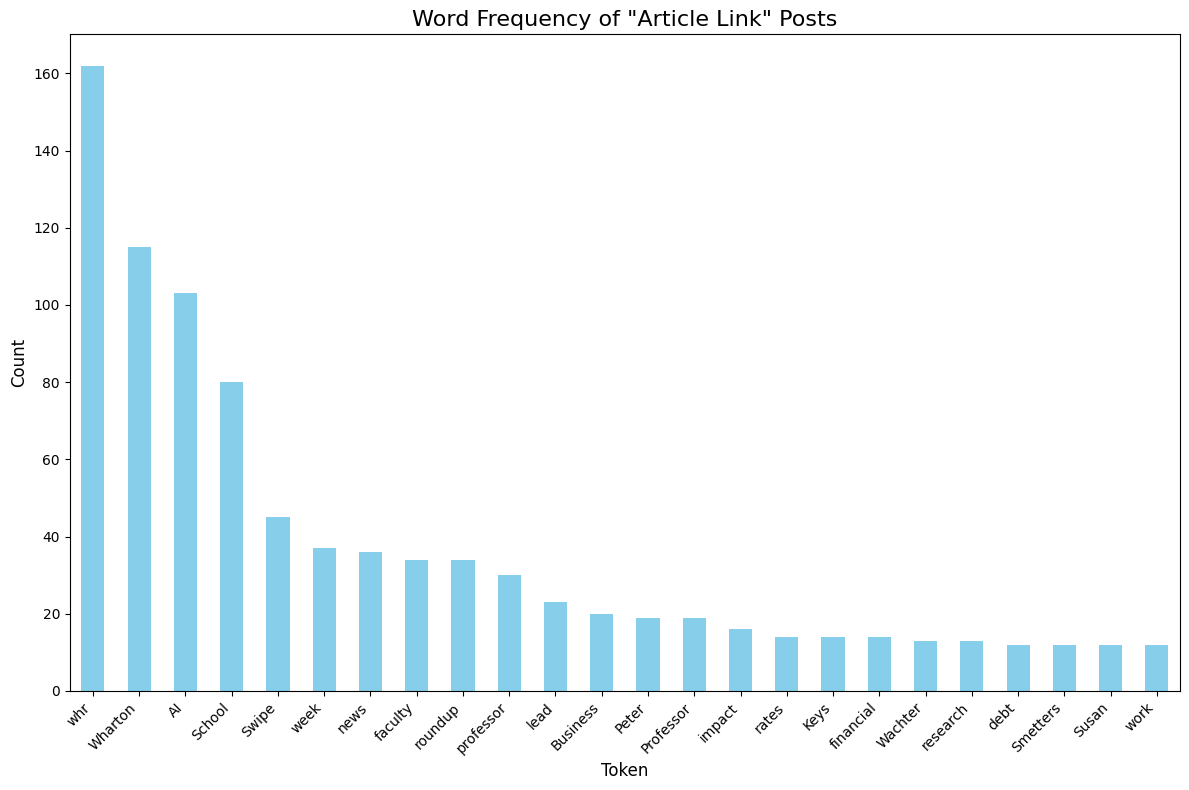

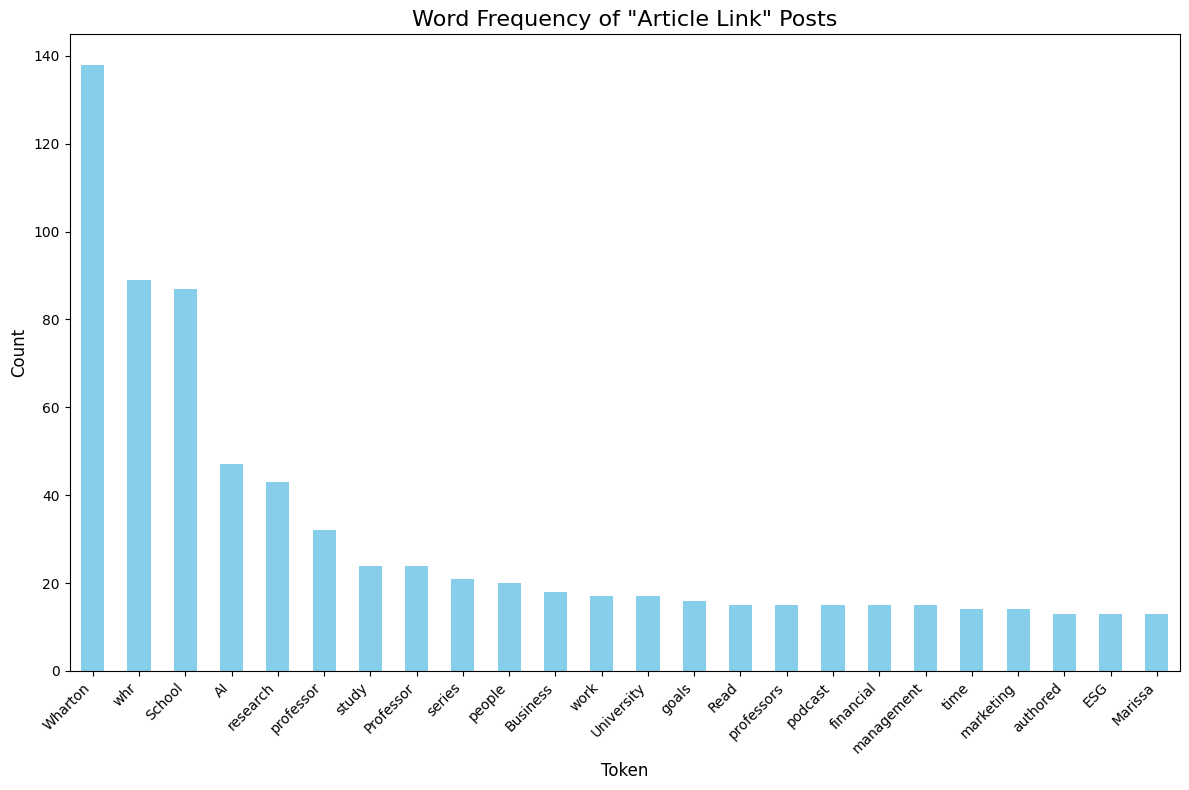

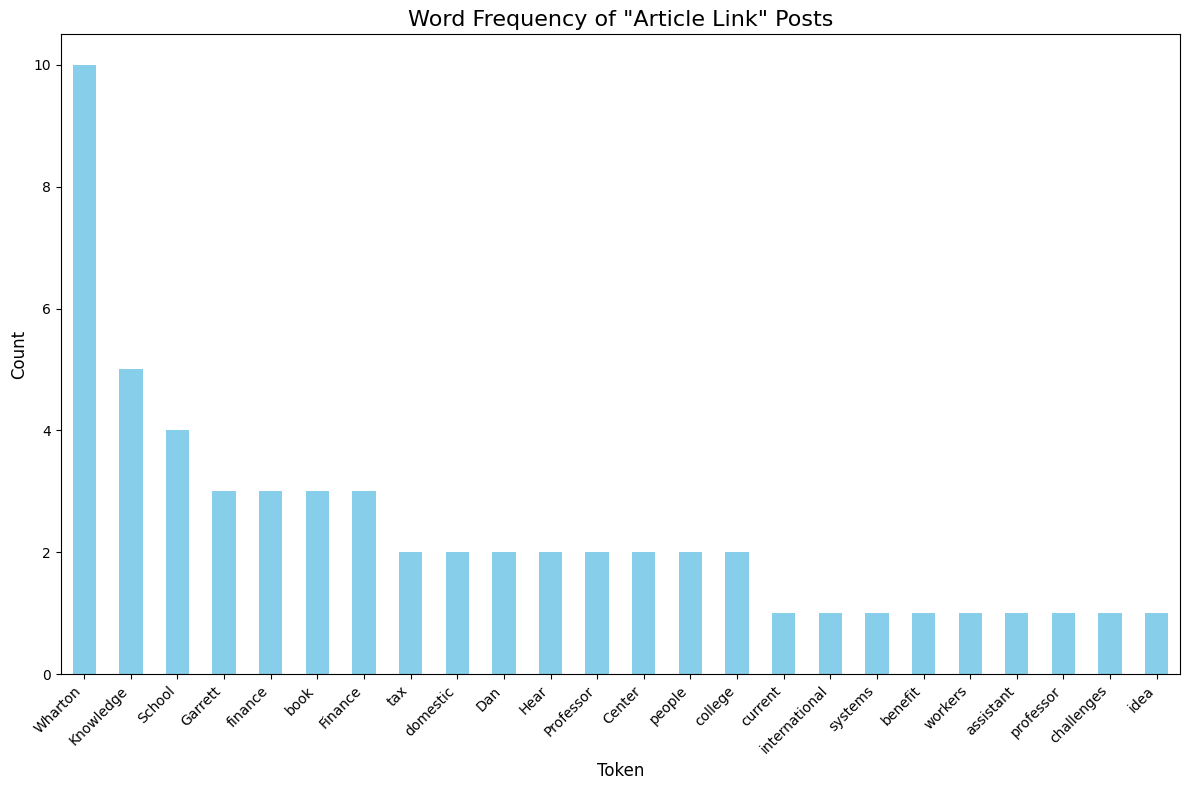

In [112]:
# Create DataFrame and plot
for account, counter in counter_lst:
    # Convert counter to DataFrame and filter out space character
    freq_df = pd.DataFrame.from_records(counter.most_common(25), columns=['token', 'count'])
    freq_df = freq_df[freq_df['token'].str.strip() != '']  # Remove empty/space-only tokens
    freq_df.plot(kind='bar', x='token', legend=False, figsize=(12, 8), color='skyblue')

    # Customize labels and title using default fonts
    plt.xlabel("Token", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.title(f'Word Frequency of "{account}" Posts', fontsize=16)
    plt.tight_layout()
    plt.show()


In [113]:
# Create document-term matrix
ct_lst = [CountVectorizer(
    tokenizer=my_tokenizer_jiagu,
    stop_words=list(stop_words),
    min_df=0.1,
    lowercase=False,
) for account, df in df_pairs]

text_ct_lst = [(account_df_pair[0], ct.fit_transform(account_df_pair[1]['content_processed'])) for account_df_pair, ct in zip(df_pairs, ct_lst)]

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", '-', '.', 'ain', 'aren', 'couldn', 'daren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', '下', '不', '乌', '儿', '唷', '啪', '年', '点儿', '登', '达'] not in stop_words.
  warnings.warn(


In [114]:
df_dtm_lst = [(account_df_pair[0], pd.DataFrame.from_records(account_df_pair[1].toarray(), columns=ct.get_feature_names_out())) for account_df_pair, ct in zip(text_ct_lst, ct_lst)]

wordcloud for Article Link posts


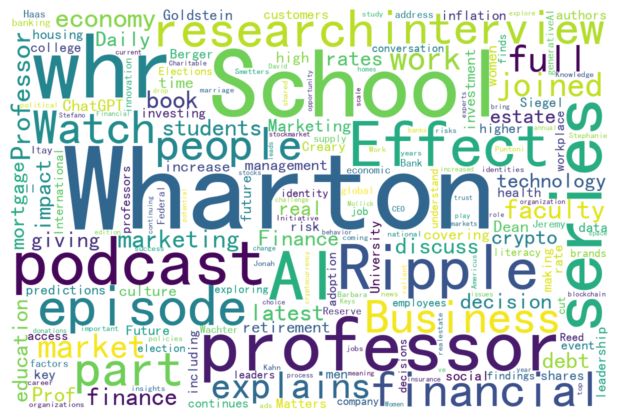

wordcloud for Article Link posts


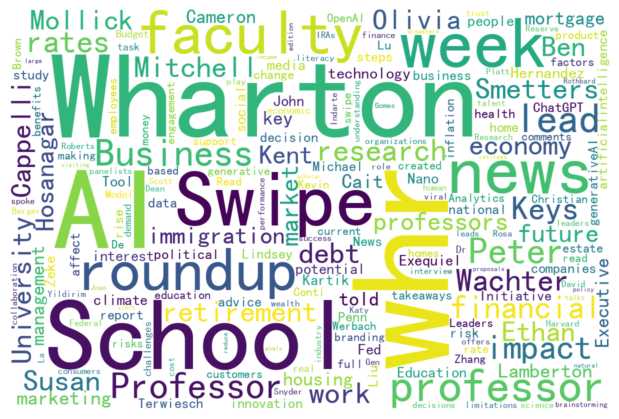

wordcloud for Article Link posts


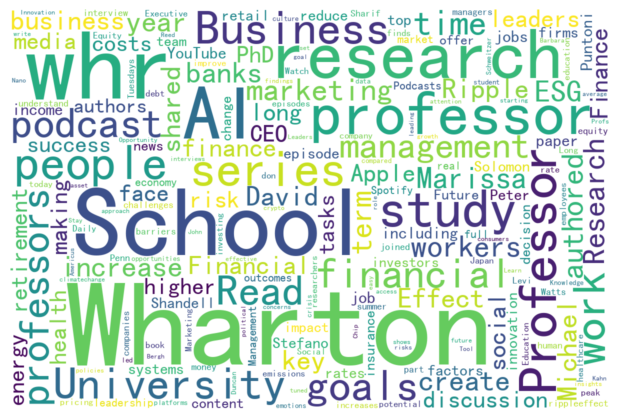

wordcloud for Article Link posts


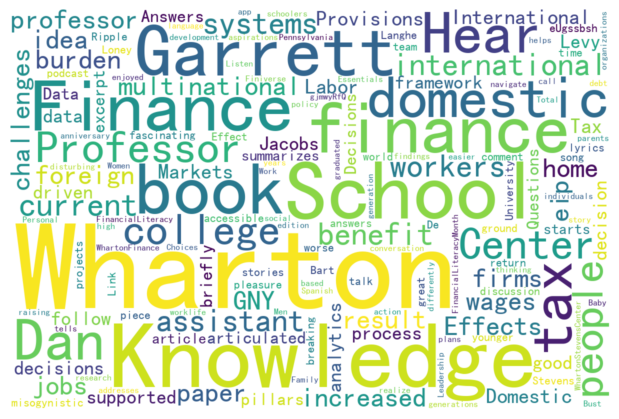

In [115]:
for account, counter in counter_lst:
  print(f"wordcloud for {account} posts")
  ## Make wordcloud
  wc = WordCloud(font_path=font_path, width=1200, height=800, background_color="white", max_words=200)
  wc.generate_from_frequencies(counter)

  #plot
  plt.figure(figsize=(6,4))
  plt.imshow(wc,interpolation='bilinear')
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show()

## SENTIMENT ANALYSIS (textblob)



In [116]:
# Define a function to calculate sentiment polarity using TextBlob
def get_polarity(text):
    if not isinstance(text, str):
        return None
    return TextBlob(text).sentiment.polarity  # Returns a float between -1.0 (negative) and 1.0 (positive)

# Apply sentiment analysis to the 'content' column
post_df['polarity_textblob'] = post_df['content'].apply(get_polarity)

# Display descriptive statistics for polarity
print(post_df['polarity_textblob'].describe())


count    267.000000
mean       0.128523
std        0.123894
min       -0.400000
25%        0.043174
50%        0.129590
75%        0.200386
max        0.536364
Name: polarity_textblob, dtype: float64


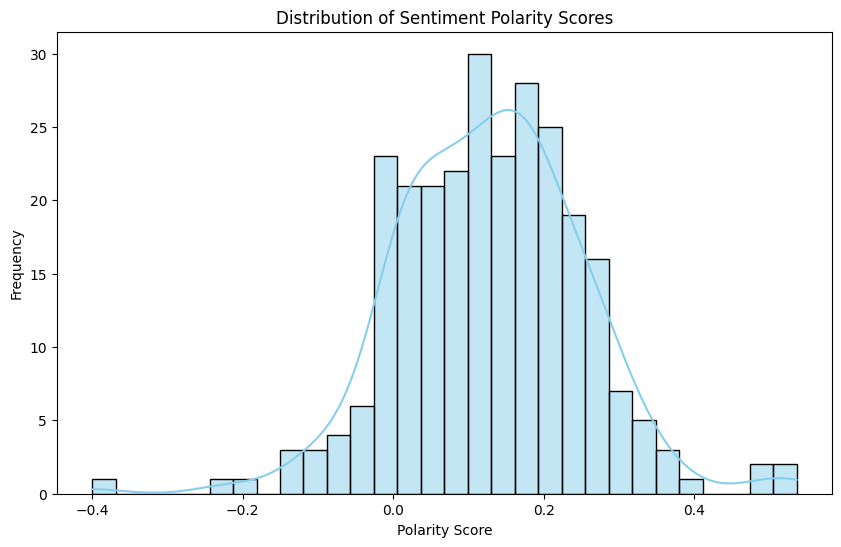

In [117]:
# Plot histogram of polarity scores
plt.figure(figsize=(10, 6))
sns.histplot(post_df['polarity_textblob'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

In [118]:
def categorize_polarity(polarity):
    if polarity >= 0.2:
        return 'Positive'
    elif polarity <= 0.0:
        return 'Negative'
    else:
        return 'Neutral'

In [119]:
# Apply categorization to the 'polarity_textblob' column
post_df['sentiment_category'] = post_df['polarity_textblob'].apply(categorize_polarity)

# Display the sentiment category counts
print(post_df['sentiment_category'].value_counts())

sentiment_category
Neutral     154
Positive     72
Negative     41
Name: count, dtype: int64


In [120]:
def display_full_text(df, column_names):
    with pd.option_context('display.max_colwidth', None):
        display(df[column_names])

# Display sample Positive Posts
print("Sample Positive Posts:")
display_full_text(post_df[post_df['sentiment_category'] == 'Positive'].head(), ['media_type', 'content'])

# Display sample Neutral Posts
print("\nSample Neutral Posts:")
display_full_text(post_df[post_df['sentiment_category'] == 'Neutral'].head(), ['media_type', 'content'])

# Display sample Negative Posts
print("\nSample Negative Posts:")
display_full_text(post_df[post_df['sentiment_category'] == 'Negative'].head(), ['media_type', 'content'])


Sample Positive Posts:


,media_type,content
6,Image,"Doing more faster at work does not necessarily make you more productive. Instead, consider embracing ""Slow Productivity,"" which emphasizes focusing on fewer, high-priority tasks to improve outcomes and reduce burnout. This Wharton Executive Education Nano Tool explains how by limiting commitments, leaders can allocate more attention to critical goals and projects, leading to higher-quality results: https://whr.tn/3PudpQc Warren Buffett’s ""5/25 Rule"" exemplifies this approach by encouraging individuals to write a list of their top 25 career goals, circle the five most important goals, and avoid the remaining 20 at all costs (or at least until the top five are achieved). hashtag # LeadershipDevelopment hashtag # Management hashtag # Productivity hashtag # TimeManagement"
7,Text,"Could AI really take over the task of processing the many documents moving within organizations – a task still largely handled by people? Research from The Wharton School's Peter Cappelli and Valery Yakubovich , and Ricoh USA, Inc.'s Braj Thakur, and Ashok Shenoy , looked into how a healthcare insurer used generative AI to streamline document classification and data extraction. While AI didn’t review or decide claims, it still tripled productivity and reduced errors. Employees were still involved in processing documents and data where the AI needed futher help. The study, highlighted in Harvard Business Review , shows how AI complements human work, emphasizing cost-effective solutions and employee involvement in implementation. Read more: https://whr.tn/3WcH9EW hashtag # GenerativeAI hashtag # GenAI hashtag # Automation hashtag # Healthcare hashtag # HealthInsurance"
10,Text,"📝 As we close out 2024, here are five takeaways from five of our most popular articles this year: 1. Retirees are better off keeping their savings in 401(k) plans instead of moving them to IRAs, especially lower-income people with limited financial literacy, according to research from finance professor Olivia S Mitchell . 2. ""There are still many versions of inequality, and the gaps have the potential to widen without any interventions,” management professor Stephanie Creary shared at the inaugural Relationships Across Differences Roundtable. 3. Happiness continues to rise with income — even beyond incomes of $500,000 or more, according to a new study from senior fellow Matt Killingsworth . 4. As a newly promoted manager, accept that social relationships with your peers must change, says management professor Peter Cappelli . Communicate your expectations clearly, give timely, objective feedback, and set boundaries with your direct reports. 5. “Once you become a bigger organization, you end up too homogenous, and you have a lot of groupthink, and it becomes harder to change and innovate,” management professor Adam Grant said during a conversation with Malcolm Gladwell."
11,Image,"As the cryptocurrency market surges into 2025, our first Ripple Effect podcast series of the year will feature four The Wharton School professors sharing their expertise on crypto. Stay tuned to Apple Podcasts, Spotify, or whr.tn/rippleeffect for episode releases on Tuesdays this month that will answer questions about consumer perceptions toward cryptocurrencies, how perceptions influence pricing, and regulation. 💰 Confidence in Cryptocurrency (a two-part episode) with David Reibstein and Z. John Zhang 💰 Cryptocurrency and Blockchains with Kevin Werbach 💰 Understanding Cryptocurrency: Confidence, Challenges, and Consumer Perceptions with Cait Lamberton hashtag # cryptocurrency hashtag # crypto hashtag # blockchain hashtag # bitcoin"
15,Video,"Our annual The Wharton School faculty predictions series kicks off with finance professor Jeremy Siegel! Let us know your thoughts on his outlook for the economy in 2025, and stay tuned to our social accounts for predictions on the housing market, AI, and the workplace. Watch Prof. Siegel’s full Wharton Business Daily interview here for


Sample Neutral Posts:


,media_type,content
0,Video,"What are the factors shaping the future of finance? Our new four-part interview series with Finance at Wharton features interviews between The Wharton School professor Itay Goldstein and innovation experts in the finance industry to explore concepts, groundbreaking research, and predictions. Watch here: whr.tn/futureoffinance Episodes include... 🏦 The Future of Banking with Loretta Mester (formerly Federal Reserve Bank of Cleveland ) and Hyun Song Shin ( Bank for International Settlements – BIS ) 🏦 New Phenomena in Behavioral and Social Investing with Matt Levine ( Bloomberg ) 🏦 The Regulatory Challenges of AI in Finance with Tobias Adrian ( International Monetary Fund ) 🏦 The Future of Financial Technology with Alesia Haas ( Coinbase ) and Michelle Lai ( Electric Coin Co. ) hashtag # finance hashtag # banking hashtag # fintech hashtag # investing"
1,Text,"How can tax and spending reforms reduce the national debt while still boosting the economy and helping lower-income households? The latest report from Kent Smetters and the Penn Wharton Budget Model analyzes a policy bundle of 13 major proposals aimed at achieving all three of those goals. Based on widely accepted economic principles rather than political agendas, the reforms also reduce carbon emissions, health care coverage gaps, and poverty among retirees. Swipe for key takeaways, and visit whr.tn/fiscalpolicy for more details. hashtag # economics hashtag # economy hashtag # fiscalpolicy hashtag # taxpolicy"
2,Image,"While leaders often succumb to ""not invented here"" (NIH) syndrome, prioritizing familiar sources over external ones, this mindset is counterproductive in today’s global marketplace, write Jusuke Ikegami , Harbir Singh , and Michael Useem . Authors of the book ""Resolute Japan: The Leaders Forging a Corporate Resurgence,"" they offer three practices all leaders can adopt from Japan's successful leadership model. Read details on the below action steps in this Wharton Executive Education Nano Tool: https://whr.tn/4g3WRJz 1. Accelerate the Flywheel: Create lasting success through consistent efforts. 2. Focus on the Long Term: Prioritize patience over quick wins. 3. Embrace Personal Appeal: Lead with humility to build trust and loyalty. hashtag # Leadership hashtag # LeadershipDevelopment hashtag # Innovation hashtag # Management hashtag # Japan"
3,Text,"Three professors weigh in on the impact of interest rates, inflation, and climate risk on real estate in this week's The Wharton School faculty in the news roundup. Swipe for... 1️⃣ Lu Liu on mortgage rates: https://whr.tn/42kAMTQ 2️⃣ Susan Wachter on housing supply and demand: https://whr.tn/42j0w2R 3️⃣ Ben Keys on climate change and natural disasters: https://whr.tn/42l23FE hashtag # realestate hashtag # housing hashtag # mortgage hashtag # interestrates"
5,Video,"For blockchain and cryptocurrency to grow, clear regulations need to be in place to address issues like fraud and investor protection, explains The Wharton School professor Kevin Werbach . Without adapting existing rules, it’s hard for entrepreneurs to innovate confidently, he says. The other necessary factor? Time. ""We're talking about fundamental re-architecting of global finance,"" Werbach adds, ""and that's not something that happens overnight."" He explains blockchain technology and looks ahead at its future in the third episode of our four-part Ripple Effect podcast series on crypto: https://whr.tn/40nDw0e hashtag # crypto hashtag # cryptocurrency hashtag # blockchain hashtag # digitalassets hashtag # fintech"



Sample Negative Posts:


,media_type,content
4,Text,"While AI is transforming industries, its resource demands are often being overlooked. Training and running models consumes large amounts of energy and water, putting pressure on vulnerable regions. The Wharton School visiting scholar Dr. Cornelia C. Walther suggests using the A-Frame– Awareness, Appreciation, Acceptance, and Accountability – to address these challenges: https://whr.tn/4gYB5bA hashtag # AI hashtag # sustainability hashtag # climateaction hashtag # energy"
16,Text,"Can an animated ad created using AI garner respect from viewers, equal to an ad created by people? Professor Kartik Hosanagar weighs in on the recent controversy surrounding an AI-generated Coca-Cola ad to lead this week's The Wharton School faculty in the news roundup. Swipe through for... 1️⃣ Hosanagar on AI-created animated ads:: https://whr.tn/3BJqyS4 2️⃣ Kevin Volpp on obesity treatments: https://whr.tn/3Bxdyix 3️⃣ Kent Smetters on home affordability: https://whr.tn/4gutLE9 4️⃣ Lindsey Cameron on airport ride-hailing: https://whr.tn/3DxVxRO 5️⃣ Peter Conti-Brown on banking regulations: https://whr.tn/4fzoWIy"
26,Text,What could the election outcome mean for the future of the Federal Reserve and the economy? Three The Wharton School professors share their expertise in this week's Wharton faculty in the news roundup: 1️⃣ Peter Conti-Brown on the Federal Reserve's independence: https://whr.tn/40GYN6Q 2️⃣ Christina Parajon Skinner on President Trump's potential ability to remove Fed leaders: https://whr.tn/4hXgR2T 3️⃣ Olivia S Mitchell on the impact of tariffs and taxes on retirement saving: https://whr.tn/40IB9aa
39,Text,"As OpenAI – recently valued at $157 billion – transitions from nonprofit to for-profit, finance professor Michael Roberts spoke with Business Insider about the impact its final valuation could have. Swipe through for this week's roundup of The Wharton School professors in the news: 1️⃣ Roberts on OpenAI's valuation: https://whr.tn/3UBi5qi 2️⃣ Henning Piezunka on Disney’s CEO search: https://whr.tn/4fPH1CP 3️⃣ Kent Smetters on the stock market: https://whr.tn/3CcnRbD"
45,Text,"The way a politician speaks — through tone, pitch, and delivery — can significantly shape voter perceptions and decisions, according to a recent study co-authored by The Wharton School professor Dean Knox: https://whr.tn/4efcQEp The study pored over 100 U.S. presidential campaign speeches to understand the impact of these non-verbal cues, in a collaboration with Taylor Damann and Christopher Lucas of Washington University in St. Louis. Through two carefully designed experiments, the researchers demonstrated that subtle changes in vocal delivery could dramatically alter how a candidate is viewed by the electorate, influencing perceptions of their passion, trustworthiness, and persuasiveness. hashtag # politics hashtag # publicspeaking hashtag # election"


# SENTIMENT ANALYSIS (OpenAI API)

In [129]:
PREFIX = '''
###### Instructions ######
I am working with posts from different master programs and need a sentiment classification on the post texts. I need your help to provide a sentiment analysis analysis.
Please note that the answer should be provided as a continuouse float value corresponding to sentiment score ranging from -1 to 1, rounded to two decimal places, without including the explanation or any additional text.
-1 represents extremely negative sentiment, 0 represents neutral sentiment, and 1 represents extremely positive sentiment.

###### Example of Desired Response ######
[Answer]: 0
'''

output_file_path = "sentiment_analysis_openAI_wharton.csv"
with open('/content/drive/MyDrive/Marketing Analytics Course Preparation/Sichen/NYU Stern Social Media/Model Creation/data/API_key.txt', 'r') as f:  # Replace with your file path
       API_key = f.read()

In [130]:
df_test = post_df

In [131]:
# Check if the output file exists, if so, load the DataFrame from it
if os.path.exists(output_file_path):
    df_test = pd.read_csv(output_file_path)
    print(f"Resuming from checkpoint, starting at row {df_test['sentiment_classifier'].last_valid_index() + 1}...")
else:
    # If there is no checkpoint, then add new columns to the original DataFrame for storing results
    df_test['sentiment_classifier'] = None


# loop through first 10 rows
i = 0
n_calls = 0
for index, row in df_test.iterrows():
    # skip if already have answer and confidence level
    if pd.notnull(row['sentiment_classifier']):
        continue

    #---------------------------- create prompt ----------------------------
    post_content = row['content']

    prompt = f"""
    Perform sentiment analysis on the following social media posts. Assign each post a sentiment score that is a continuous float value ranging from -1.0 to 1.0, rounded to two decimal places, where:
    - A score close to -1.0 indicates extremely negative sentiment.
    - A score close to 0.0 indicates neutral sentiment.
    - A score close to 1.0 indicates extremely positive sentiment.
    Please note that the answer should be provided as a single float corresponding\
    to the provided text's sentiment score, without including the explanation or any additional text."

    Text to analyse: ```{post_content}```
    """

    # ---------------------------- send message and get response ----------------------------
    message = [
        {
            "role": "system",
            "content": "I am a language model designed to generate sentiment analysis on master programs posts. Please help by providing one float rounded to two decimal places as sentiment score based on the text from social media post."
        },
        {"role": "user", "content": prompt}
    ]


    try:
        openai.api_key = API_key
        response = openai.ChatCompletion.create(
                model="gpt-4o",
                messages=message
            )
        n_calls += 1

    #---------------------------- parse response ----------------------------
        output = response['choices'][0]['message']['content'].strip()
        print(f"====== output for {post_content[:50]}, {output} ======")
        print(output)
        # update dataframe

        df_test.at[index, 'sentiment_classifier'] = output

    # ---------------------------- error handling and save checkpoint ----------------------------
    except Exception as e:
        print('Error occured at row: ', index, ' with error: ', e)
        # Sleep for 10 seconds to avoid rate limit
        time.sleep(10)

    # save checkpoint
    df_test.to_csv(output_file_path, index=False)

    # sleep for 20 second to avoid rate limit every 10 calls
    if n_calls % 10 == 0:
        print(f"Sleeping for 20 seconds to avoid rate limit...")
        time.sleep(20)

====== output for What are the factors shaping the future of finance, 0.20 ======
0.20
====== output for How can tax and spending reforms reduce the nation, 0.20 ======
0.20
====== output for While leaders often succumb to "not invented here", 0.15 ======
0.15
====== output for Three professors weigh in on the impact of interes, 0.00 ======
0.00
====== output for While AI is transforming industries, its resource , 0.05 ======
0.05
====== output for For blockchain and cryptocurrency to grow, clear r, 0.15 ======
0.15
====== output for Doing more faster at work does not necessarily mak, 0.25 ======
0.25
====== output for Could AI really take over the task of processing t, 0.50 ======
0.50
====== output for What's one word to describe the U.S. economy in 20, 0.10 ======
0.10
====== output for Heading into 2025, we asked four   The Wharton Sch, 0.15 ======
0.15
Sleeping for 20 seconds to avoid rate limit...
====== output for 📝 As we close out 2024, here are five takeaways fr, 0.10 ======
0

In [132]:
gpt_sentiment = pd.read_csv("sentiment_analysis_openAI_wharton.csv")
gpt_sentiment.head()

,row_number,post_date,content,like_count,comments,media_type,image_url,video_url,article_url,content_processed,polarity_textblob,sentiment_category,sentiment_classifier
0,1,"12/9/24, 11:01AM (EST)",What are the factors shaping the future of fin...,437,4,Video,No images,https://dms.licdn.com/playlist/vid/dynamic/D56...,https://www.linkedin.com/feed/hashtag/?keyword...,factors shaping future finance part interview ...,0.030606,Neutral,0.20
1,2,"1/22/25, 1:00PM (EST)",How can tax and spending reforms reduce the na...,13,0,Text,No images,No videos,https://www.linkedin.com/feed/hashtag/?keyword...,tax spending reforms reduce national debt boos...,0.166071,Neutral,0.20
2,3,"1/17/25, 8:45AM (EST)","While leaders often succumb to ""not invented h...",34,0,Image,https://media.licdn.com/dms/image/v2/D4E10AQGn...,No videos,https://www.linkedin.com/feed/hashtag/?keyword...,leaders succumb invented NIH syndrome prioriti...,0.181410,Neutral,0.15
3,4,"1/20/25, 9:00AM (EST)",Three professors weigh in on the impact of int...,3,0,Text,No images,No videos,https://www.linkedin.com/in/ACoAABbbHCIBpUmuGM...,professors weigh impact interest rates inflati...,0.150000,Neutral,0.00
4,5,"1/16/25, 3:21PM (EST)","While AI is transforming industries, its resou...",14,1,Text,No images,No videos,https://www.linkedin.com/feed/hashtag/?keyword...,AI transforming industries resource demands ov...,-0.142857,Negative,0.05


In [133]:
gpt_sentiment.groupby("media_type")['sentiment_classifier'].mean()

,sentiment_classifier
media_type,
Article Link,0.310000
Image,0.213333
Text,0.147250
Video,0.227375


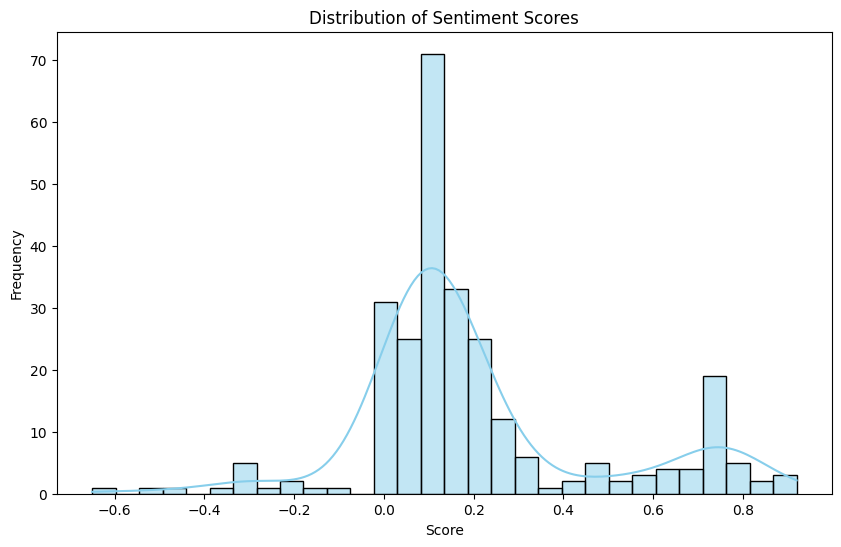

In [138]:
# Plot histogram of polarity scores
plt.figure(figsize=(10, 6))
sns.histplot(gpt_sentiment['sentiment_classifier'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [142]:
# show some positive examples
display_full_text(gpt_sentiment[gpt_sentiment['sentiment_classifier'] > 0.2].head(), ['media_type', 'content'])

,media_type,content
6,Image,"Doing more faster at work does not necessarily make you more productive. Instead, consider embracing ""Slow Productivity,"" which emphasizes focusing on fewer, high-priority tasks to improve outcomes and reduce burnout. This Wharton Executive Education Nano Tool explains how by limiting commitments, leaders can allocate more attention to critical goals and projects, leading to higher-quality results: https://whr.tn/3PudpQc Warren Buffett’s ""5/25 Rule"" exemplifies this approach by encouraging individuals to write a list of their top 25 career goals, circle the five most important goals, and avoid the remaining 20 at all costs (or at least until the top five are achieved). hashtag # LeadershipDevelopment hashtag # Management hashtag # Productivity hashtag # TimeManagement"
7,Text,"Could AI really take over the task of processing the many documents moving within organizations – a task still largely handled by people? Research from The Wharton School's Peter Cappelli and Valery Yakubovich , and Ricoh USA, Inc.'s Braj Thakur, and Ashok Shenoy , looked into how a healthcare insurer used generative AI to streamline document classification and data extraction. While AI didn’t review or decide claims, it still tripled productivity and reduced errors. Employees were still involved in processing documents and data where the AI needed futher help. The study, highlighted in Harvard Business Review , shows how AI complements human work, emphasizing cost-effective solutions and employee involvement in implementation. Read more: https://whr.tn/3WcH9EW hashtag # GenerativeAI hashtag # GenAI hashtag # Automation hashtag # Healthcare hashtag # HealthInsurance"
13,Video,"Consumer confidence is a key factor in cryptocurrency price movements, according to The Wharton School professors David Reibstein and John Zhang , who joined our Ripple Effect podcast for a two-part interview to open our series on crypto: https://whr.tn/403tuRz Their Consumer Cryptocurrency Confidence Index (c3i) tracks public sentiment, including trust in crypto and willingness to invest, revealing a strong link between confidence and price trends. There's been an evolution in the people accepting, gaining confidence, and investing in crypto, says Reibstein. Early investors were risk-takers and then believers in technology, but now people are choosing to invest as a way to avoid putting trust in centralized institutions. hashtag # crypto hashtag # cryptocurrency hashtag # bitcoin hashtag # blockchain hashtag # ethereum"
23,Text,"“The potential benefits of AI in financial advice are too great to ignore,"" writes Sarah Hammer , an Executive Director leading financial technology initiatives at The Wharton School . Swipe for steps both individuals and advisers can take to implement AI responsibly, and read more here: https://whr.tn/48YzsHu . hashtag # AI hashtag # generativeAI hashtag # ChatGPT hashtag # financialadvice hashtag # financialadviser"
27,Video,"They say ""comparison is the thief of joy,"" and this can ring especially true during the holiday season. The Wharton School professor Maurice Schweitzer , who's focused much of his research on emotions, has found that we tend to compare ourselves to other people to give meaning to our own lives. He recommends making it your goal to ""have a more balanced and broader view,"" identifying opportunities to express gratitude for what you have. hashtag # gratitude hashtag # wellbeing hashtag # happiness hashtag # psychology"


In [141]:
# show some neutral examples
display_full_text(gpt_sentiment[(gpt_sentiment['sentiment_classifier'] <= 0.2)&(gpt_sentiment['sentiment_classifier'] >= 0.0)].head(), ['media_type', 'content'])

,media_type,content
0,Video,"What are the factors shaping the future of finance? Our new four-part interview series with Finance at Wharton features interviews between The Wharton School professor Itay Goldstein and innovation experts in the finance industry to explore concepts, groundbreaking research, and predictions. Watch here: whr.tn/futureoffinance Episodes include... 🏦 The Future of Banking with Loretta Mester (formerly Federal Reserve Bank of Cleveland ) and Hyun Song Shin ( Bank for International Settlements – BIS ) 🏦 New Phenomena in Behavioral and Social Investing with Matt Levine ( Bloomberg ) 🏦 The Regulatory Challenges of AI in Finance with Tobias Adrian ( International Monetary Fund ) 🏦 The Future of Financial Technology with Alesia Haas ( Coinbase ) and Michelle Lai ( Electric Coin Co. ) hashtag # finance hashtag # banking hashtag # fintech hashtag # investing"
1,Text,"How can tax and spending reforms reduce the national debt while still boosting the economy and helping lower-income households? The latest report from Kent Smetters and the Penn Wharton Budget Model analyzes a policy bundle of 13 major proposals aimed at achieving all three of those goals. Based on widely accepted economic principles rather than political agendas, the reforms also reduce carbon emissions, health care coverage gaps, and poverty among retirees. Swipe for key takeaways, and visit whr.tn/fiscalpolicy for more details. hashtag # economics hashtag # economy hashtag # fiscalpolicy hashtag # taxpolicy"
2,Image,"While leaders often succumb to ""not invented here"" (NIH) syndrome, prioritizing familiar sources over external ones, this mindset is counterproductive in today’s global marketplace, write Jusuke Ikegami , Harbir Singh , and Michael Useem . Authors of the book ""Resolute Japan: The Leaders Forging a Corporate Resurgence,"" they offer three practices all leaders can adopt from Japan's successful leadership model. Read details on the below action steps in this Wharton Executive Education Nano Tool: https://whr.tn/4g3WRJz 1. Accelerate the Flywheel: Create lasting success through consistent efforts. 2. Focus on the Long Term: Prioritize patience over quick wins. 3. Embrace Personal Appeal: Lead with humility to build trust and loyalty. hashtag # Leadership hashtag # LeadershipDevelopment hashtag # Innovation hashtag # Management hashtag # Japan"
3,Text,"Three professors weigh in on the impact of interest rates, inflation, and climate risk on real estate in this week's The Wharton School faculty in the news roundup. Swipe for... 1️⃣ Lu Liu on mortgage rates: https://whr.tn/42kAMTQ 2️⃣ Susan Wachter on housing supply and demand: https://whr.tn/42j0w2R 3️⃣ Ben Keys on climate change and natural disasters: https://whr.tn/42l23FE hashtag # realestate hashtag # housing hashtag # mortgage hashtag # interestrates"
4,Text,"While AI is transforming industries, its resource demands are often being overlooked. Training and running models consumes large amounts of energy and water, putting pressure on vulnerable regions. The Wharton School visiting scholar Dr. Cornelia C. Walther suggests using the A-Frame– Awareness, Appreciation, Acceptance, and Accountability – to address these challenges: https://whr.tn/4gYB5bA hashtag # AI hashtag # sustainability hashtag # climateaction hashtag # energy"


In [143]:
# show some negative examples
display_full_text(gpt_sentiment[gpt_sentiment['sentiment_classifier'] <0.0].head(), ['media_type', 'content'])

,media_type,content
30,Image,"Corporate carbon emissions carry hidden costs that are bigger than many realize, new research from The Wharton School 's Robert Stambaugh and Luke Taylor finds: https://whr.tn/3BSDViV Their “carbon burden” metric shows that the societal costs of emissions often outweigh a company’s market value, highlighting the long-term climate damage caused by corporate activities. This creates challenges for balancing business success with environmental responsibility. The study emphasizes the need for effective, fair policies to help companies reduce their emissions while addressing these significant social and environmental impacts. 📝: Finance at Wharton hashtag # ESG hashtag # ESGinvesting hashtag # emissions hashtag # climatechange"
34,Video,"Picture this: You arrive to the first day of your job, excited and committed to your new opportunity. A few weeks in, you find out that you weren't the company's top choice during the hiring process. What impact does this have? The Wharton School management professor Samir Nurmohamed , who researches experiences of adversity at work, looked into the effects of being an alternate-choice hire: https://whr.tn/4fdIzFG He found that these ""runner-ups"" feel less socially integrated and a lower sense of belonging while feeling more distant from their co-workers. As a result, they seek less guidance and feedback in their new roles. To mitigate this, leaders can establish that not being the first choice is normal, proactively create a plan around disclosure, and build connections with other employees who share the same story. hashtag # management hashtag # peoplemanagement hashtag # humanresources hashtag # hr"
35,Text,"AI can make purchasing products easier – a win for companies' profits, but one that could curb consumers' good financial decision-making. The Wharton School professor Wendy De La Rosa , who researches financial wellness, created the ""AI-IMPACT"" model to assess how AI will impact consumer decision-making, and capitalize on consumers' vulnerabilities. “When you think of individual human beings trying to fight against hundreds, if not thousands, of companies now equipped with artificial intelligence technology, there’s room for concern,"" De La Rosa told Wharton Business Daily. Read more: https://whr.tn/4dZmt9h hashtag # financialwellness hashtag # financialeducation hashtag # consumerbehavior hashtag # budgeting"
60,Video,"While another Federal Reserve rate cut last week may feel like a win for consumers, The Wharton School professor Ben Keys explains why it may not impact loan rates in the way that many may hope. Keys sees the supply and affordability issues in the housing market continuing as borrowing costs stay high, particularly with additional tax cuts and a round of tariffs expected on the horizon. hashtag # realestate hashtag # mortgage hashtag # federalreserve hashtag # interestrates"
90,Video,"The U.S. has a national debt problem, and a crisis is coming if the federal government doesn't take action, warns The Wharton School finance professor Joao Gomes . To open our six-part Ripple Effect podcast series on the ""Business of Elections,"" Gomes explains that foreign trust in the U.S. government has provided ""a reliable, cheap source of funds."" If that trust wanes and the debt continues its rise, every part of the economy will be impacted, he says, ""from the banking system and our bank deposits to our paychecks, to Social Security and Medicare."" Watch the full interview: https://whr.tn/4eLKdPi hashtag # financialmarkets hashtag # macroeconomics hashtag # economy hashtag # monetarypolicy"


# TOPIC MODELING

In [178]:
#LatentDirichletAllocation
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    #distribution over the words for each topic after normalization
    model_distribution=model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    final_df=pd.DataFrame()

    for topic_idx, topic in enumerate(model_distribution):

        topic_num=int(topic_idx)+1
        print("\nTopic #%d:" % topic_num)
        dict_={}

        for i in topic.argsort()[:-n_top_words - 1:-1]:
            dict_[words[i]]=topic[i]

        lda_df=pd.DataFrame.from_dict(dict_,orient='index')
        lda_df.columns=['Probability']
        lda_df['topic']=topic_idx+1
        lda_df['rank']=lda_df['Probability'].rank().astype('int')
        final_df = pd.concat([final_df, lda_df])

        print(lda_df)

    return final_df

# Function to compute perplexity for a range of topics
def calculate_perplexity(text_ct, topic_range):
    perplexity_scores = []
    for n_topics in topic_range:
        lda = LDA(n_components=n_topics, n_jobs=-1, random_state=42)
        lda_fitted = lda.fit(text_ct)
        perplexities = lda.perplexity(text_ct)
        perplexity_scores.append(perplexities)
    return perplexity_scores

# Function to compute coherence scores
def calculate_coherence(text_ct, topic_range):
    coherence_scores = []
    for n_topics in topic_range:
        lda = LDA(n_components=n_topics, n_jobs=-1, random_state=42)
        lda_fitted = lda.fit(text_ct)
        lda_topics = [[dictionary[word_id] for word_id in topic.argsort()[-10:]]
                      for topic in lda.components_]
        coherence_model = CoherenceModel(topics=lda_topics, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherence_model.get_coherence())
    return coherence_scores

In [179]:
# update the stop words for topic modeling to avoid dominancy of some accounts
stop_topic_modeling = list(stop_words) + ['Wharton', 'whr']

In [180]:
df_concat = pd.concat([*map(lambda x: x[1], df_pairs)], axis=0, ignore_index=True)
df_concat = df_concat[df_concat['content_processed'].str.strip() != '']
ct = CountVectorizer(tokenizer=my_tokenizer_jiagu, stop_words=stop_topic_modeling, min_df=0.1, lowercase=False)
text_ct = ct.fit_transform(df_concat['content_processed'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", '-', '.', 'ain', 'aren', 'couldn', 'daren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', '下', '不', '乌', '儿', '唷', '啪', '年', '点儿', '登', '达'] not in stop_words.
  warnings.warn(


In [181]:
# Get the sum of counts for each token across all documents
token_counts = np.array(text_ct.sum(axis=0)).flatten()

# Get the feature names (tokens)
tokens = ct.get_feature_names_out()

# Create a DataFrame for better visualization
token_count_df = pd.DataFrame({'token': tokens, 'count': token_counts})

# Optionally, sort the DataFrame by count in descending order
token_count_df = token_count_df.sort_values(by='count', ascending=False).reset_index(drop=True)

token_count_df.to_csv("token_count.csv", index=False)

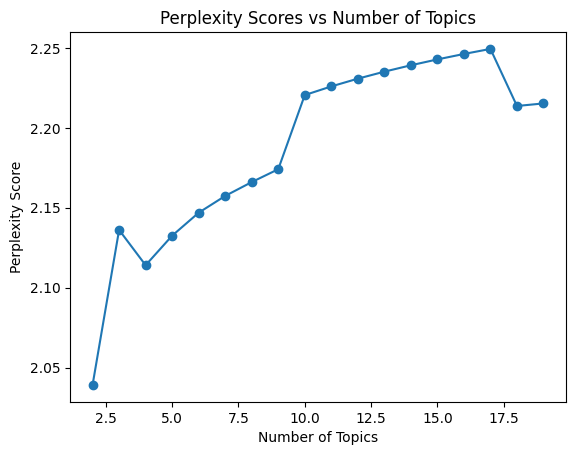

Optimal number of topics: 2


In [182]:
# Perplexity score is a statistical measure used to evaluate how well a topic model predicrts a set of
# unseen documents. It gauges the model's generalization ability, with lower perlexity scores indicating
# better performance.


# Define topic range to test
topic_range = range(2, 20)

# Calculate perplexity scores for each number of topics
perplexity_scores = calculate_perplexity(text_ct, topic_range)

# Plot the results
plt.plot(topic_range, perplexity_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.title('Perplexity Scores vs Number of Topics')
plt.show()

# Optimal number of topics (minimum perplexity)
optimal_topics = topic_range[np.argmin(perplexity_scores)]
print(f"Optimal number of topics: {optimal_topics}")


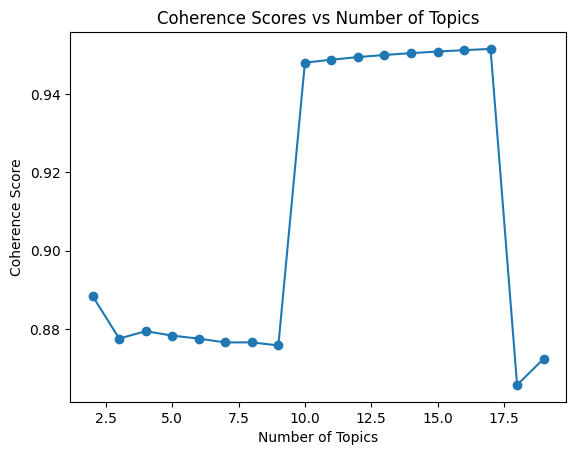

Optimal number of topics: 17


In [183]:
# Coherence score: metric used in topic modeling to measure the quality of the generated topics.
# it evalutes how semantically meaningful or interpretable a topic is, based on the relationships
# between the words within that topic.
tokenized_texts = df_concat['content_processed'].apply(my_tokenizer_jiagu).to_list()
dictionary = Dictionary(tokenized_texts)

# # Bag-of-words representation
# corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Calculate coherence scores
coherence_scores = calculate_coherence(text_ct, topic_range)

# Plot the results
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores vs Number of Topics')
plt.show()

# Optimal number of topics (maximum coherence)
optimal_topics = topic_range[np.argmax(coherence_scores)]
print(f"Optimal number of topics: {optimal_topics}")

In [184]:
number_words = 10 # Number of words in each topic

# Create and fit the LDA model
lda_model = LDA(n_components=5, n_jobs=-1, random_state=42)
lda_output = lda_model.fit(text_ct)

# Print the topics found by the LDA model
print("Topics found via LDA:")
lda_summary = print_topics(lda_model, ct, number_words)

Topics found via LDA:

Topic #1:
           Probability  topic  rank
              0.897878      1    10
AI            0.017582      1     9
School        0.016175      1     8
professor     0.006038      1     7
research      0.005793      1     6
Professor     0.005582      1     5
news          0.004574      1     4
Business      0.004501      1     3
Swipe         0.004202      1     2
week          0.004109      1     1

Topic #2:
            Probability  topic  rank
Professor      0.033406      2    10
professors     0.033400      2     9
Peter          0.033392      2     8
faculty        0.033380      2     7
market         0.033376      2     6
impact         0.033375      2     5
School         0.033372      2     4
               0.033369      2     3
full           0.033366      2     2
interview      0.033365      2     1

Topic #3:
            Probability  topic  rank
Professor      0.033406      3    10
professors     0.033400      3     9
Peter          0.033392      3 

In [189]:
# Sum lda
lda_summary['topic'] = lda_summary['topic'].astype(int)
lda_summary = lda_summary.reset_index()
lda_summary

,level_0,index,Probability,topic,rank
0,0,,0.897878,1,10
1,1,AI,0.017582,1,9
2,2,School,0.016175,1,8
3,3,professor,0.006038,1,7
4,4,research,0.005793,1,6
5,5,Professor,0.005582,1,5
6,6,news,0.004574,1,4
7,7,Business,0.004501,1,3
8,8,Swipe,0.004202,1,2
9,9,week,0.004109,1,1


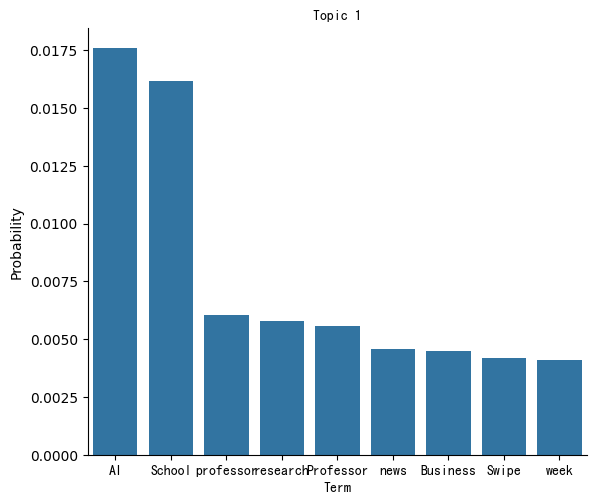

In [191]:
# topic 1
topic1 = lda_summary[(lda_summary['topic'] == 1) & (lda_summary['index'].str.strip() != '')]
sns.catplot(x='index', y='Probability', data=topic1, kind='bar',aspect=1.2)
plt.title('Topic 1', fontproperties=custom_font)
plt.xlabel('Term', fontproperties=custom_font)
plt.xticks(fontproperties=custom_font)
plt.show()

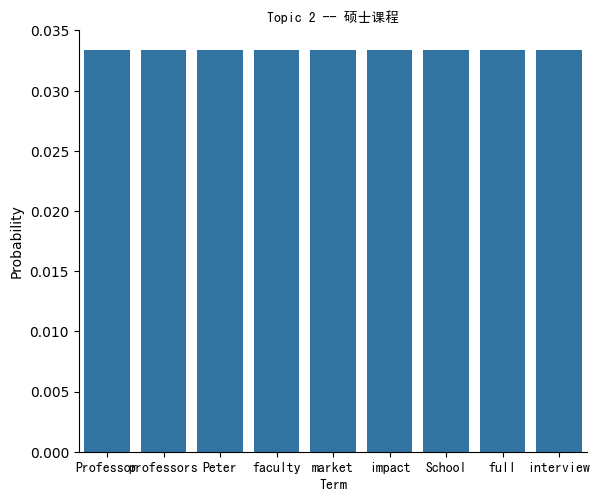

In [193]:
# topic 2
topic2 = lda_summary[(lda_summary['topic'] == 2) & (lda_summary['index'].str.strip() != '')]
sns.catplot(x='index', y='Probability', data=topic2, kind='bar',aspect=1.2)
plt.title('Topic 2', fontproperties=custom_font)
plt.xlabel('Term', fontproperties=custom_font)
plt.xticks(fontproperties=custom_font)
plt.show()

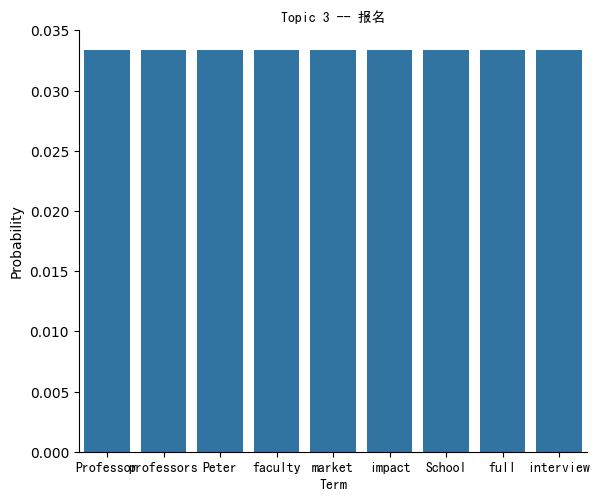

In [194]:
# topic 3
topic3 = lda_summary[(lda_summary['topic'] == 3) & (lda_summary['index'].str.strip() != '')]
sns.catplot(x='index', y='Probability', data=topic3, kind='bar',aspect=1.2)
plt.title('Topic 3', fontproperties=custom_font)
plt.xlabel('Term', fontproperties=custom_font)
plt.xticks(fontproperties=custom_font)
plt.show()

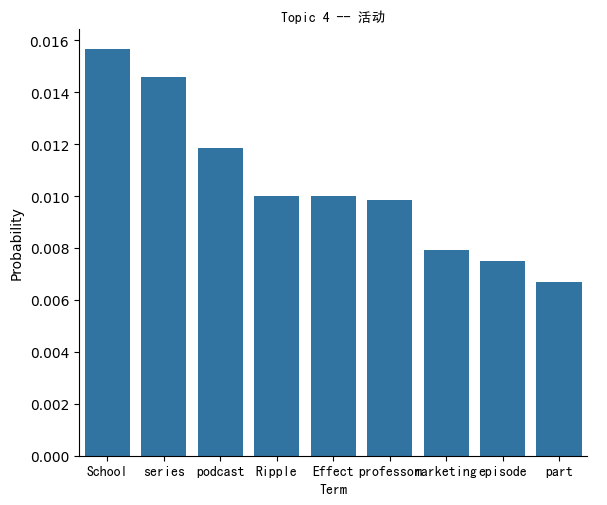

In [195]:
# topic 4
topic4 = lda_summary[(lda_summary['topic'] == 4) & (lda_summary['index'].str.strip() != '')]
sns.catplot(x='index', y='Probability', data=topic4, kind='bar',aspect=1.2)
plt.title('Topic 4 -- 活动', fontproperties=custom_font)
plt.xlabel('Term', fontproperties=custom_font)
plt.xticks(fontproperties=custom_font)
plt.show()

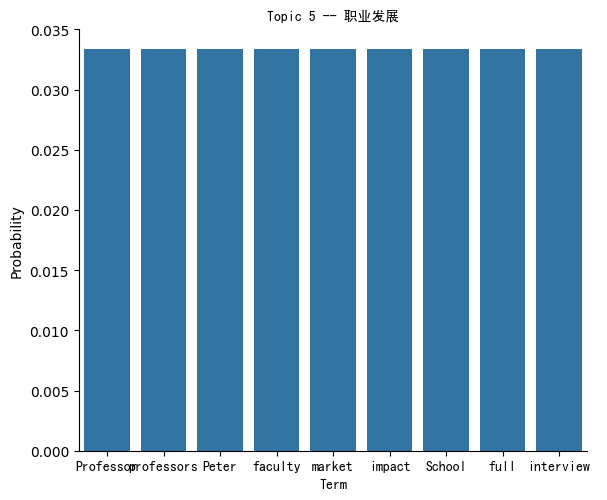

In [196]:
# topic 5
topic5 = lda_summary[(lda_summary['topic'] == 5) & (lda_summary['index'].str.strip() != '')]
sns.catplot(x='index', y='Probability', data=topic5, kind='bar',aspect=1.2)
plt.title('Topic 5 -- 职业发展', fontproperties=custom_font)
plt.xlabel('Term', fontproperties=custom_font)
plt.xticks(fontproperties=custom_font)
plt.show()

In [197]:
doc_topic_matrix = lda_model.transform(text_ct)
doc_topic_df = pd.DataFrame(doc_topic_matrix)
topic_lst = [f"Topic {i+1}" for i in range(lda_model.n_components)]
doc_topic_df.columns = topic_lst
doc_topic_df = doc_topic_df
doc_topic_df = pd.concat([df_concat, doc_topic_df], axis = 1)

In [199]:
topic_summary_lst = ["Average contribution to topic 1 (硕士生活分享)",
"Average contribution to topic 2 (硕士课程)",
"Average contribution to topic 3 (报名)",
"Average contribution to topic 4 (活动)",
"Average contribution to topic 5 (职业发展)"]
dictionary_rename_columns = dict(zip(topic_lst, topic_summary_lst))
doc_topic_matrix = doc_topic_df.groupby("media_type")[topic_lst].mean().rename(columns = dictionary_rename_columns)
# doc_topic_matrix.to_csv("doc_topic_matrix.csv")
doc_topic_matrix

,Average contribution to topic 1 (硕士生活分享),Average contribution to topic 2 (硕士课程),Average contribution to topic 3 (报名),Average contribution to topic 4 (活动),Average contribution to topic 5 (职业发展)
media_type,,,,,
Article Link,0.829869,0.007827,0.007827,0.146651,0.007827
Image,0.751258,0.003583,0.003583,0.237993,0.003583
Text,0.913888,0.004096,0.004096,0.073823,0.004096
Video,0.362021,0.003515,0.003515,0.627435,0.003515


# Post Metric Prediction

In [239]:
from sentence_transformers import SentenceTransformer

# Initialize the English SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose other English models as needed

# Our sentences we like to encode (English examples)
sentences = [
    "Moka's text embedding model is trained and open-sourced by MokaAI, using the UniEM scripts.",
    "Massive text embedding model trained on a dataset of millions of English sentence pairs.",
    "Mixed text embedding model supports bilingual (English-Spanish) semantic similarity calculations and heterogeneous text retrieval, with future support for code retrieval, all in one."
]

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("\n")  # Add a newline for better readability


Sentence: Moka's text embedding model is trained and open-sourced by MokaAI, using the UniEM scripts.
Embedding: [-3.20548043e-02 -8.29707682e-02 -3.85822393e-02  6.26317784e-02
  4.61008623e-02  4.76150885e-02 -7.95392171e-02 -6.97995769e-03
  5.81825487e-02 -8.05327073e-02  2.79939584e-02  2.72206105e-02
  7.77559802e-02  4.84170094e-02  6.86117634e-03  4.56382744e-02
  8.16195011e-02  5.69124743e-02 -1.55503070e-02 -5.96738905e-02
  9.28012282e-03  1.63833909e-02  1.15573741e-01 -7.01108873e-02
  4.30803560e-02  2.12751329e-02 -6.33780332e-03  3.95066403e-02
  4.08894233e-02 -4.55814973e-02  3.96162160e-02  1.61715969e-02
  7.53545854e-03  7.38241971e-02 -4.70727636e-03  8.30552503e-02
 -4.55281325e-02  6.14968799e-02 -2.63725929e-02  7.88869262e-02
  2.40692757e-02  3.43298018e-02 -1.60946362e-02  5.12309521e-02
  1.33110672e-01 -3.17991264e-02 -1.00701690e-01 -2.58706529e-02
 -9.07622352e-02  6.78837970e-02 -9.70819741e-02 -5.77217378e-02
 -3.76784950e-02  7.14103878e-02 -1.711509

In [240]:
tokenized_post = list(model.encode(post_df['content_processed'].tolist()))

In [241]:
tokenized_post = np.array(tokenized_post)

In [242]:
tokenized_post.shape

(267, 384)

In [243]:
# Split into X (features) and y (target)
X = tokenized_post  # Assuming embeddings are the only features
y = post_df["like_count"].to_numpy()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42  # 70% for testing
)

In [244]:
print(X)

[[ 0.01815705 -0.01334048 -0.04453501 ... -0.03326345  0.0431441
  -0.03320403]
 [-0.03129693  0.00317885  0.03898446 ... -0.02739181  0.00415315
   0.01441981]
 [-0.01908709 -0.0072761   0.00279104 ... -0.05372937 -0.04153538
   0.09982606]
 ...
 [-0.00111947  0.03685432  0.02272041 ...  0.00444519 -0.00494111
   0.02452854]
 [ 0.08656933 -0.08221182  0.01672572 ...  0.05999231 -0.0583872
   0.01824973]
 [ 0.00874501 -0.01654434  0.03090529 ... -0.02253762 -0.00232321
   0.00962643]]


## Lasso Regression

In [231]:
from sklearn.model_selection import GridSearchCV
# Create and train the Lasso regression model

lasso_model = Lasso(random_state=42)  # alpha is the regularization strength

# Define the hyperparameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Use GridSearchCV for tuning
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Get the results
results = pd.DataFrame(grid_search.cv_results_)

# Display key columns for analysis
results_summary = results[['param_alpha', 'mean_test_score', 'std_test_score']]
print("Hyperparameter Tuning Results:")
print(results_summary)

# Get the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"\nBest alpha: {best_alpha}")

# Evaluate on the training set
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Results:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nTest Results:")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Hyperparameter Tuning Results:
   param_alpha  mean_test_score  std_test_score
0        0.001    -3.321230e+00    6.642459e+00
1        0.010    -6.112973e-08    1.203985e-07
2        0.100    -6.112973e-06    1.203985e-05
3        1.000    -6.112973e-04    1.203985e-03
4       10.000    -6.112973e-02    1.203985e-01

Best alpha: 0.01

Training Results:
Training MSE: 0.0000
Training R²: 1.0000

Test Results:
Test MSE: 0.0000
Test R²: 1.0000


## XGBoost Regression

In [245]:
from xgboost import XGBRegressor

# Define the XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_child_weight': [5, 7, 9]
}

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("\nBest Hyperparameters:")
print(best_params)

# Evaluate the best model on the training set
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Results:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")

# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nTest Results:")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {test_r2:.4f}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best Hyperparameters:
{'learning_rate': 0.001, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100, 'subsample': 1.0}

Training Results:
Training MSE: 20422.9565
Training R²: 0.0351

Test Results:
Test MSE: 21990.9815
Test R²: -0.0194


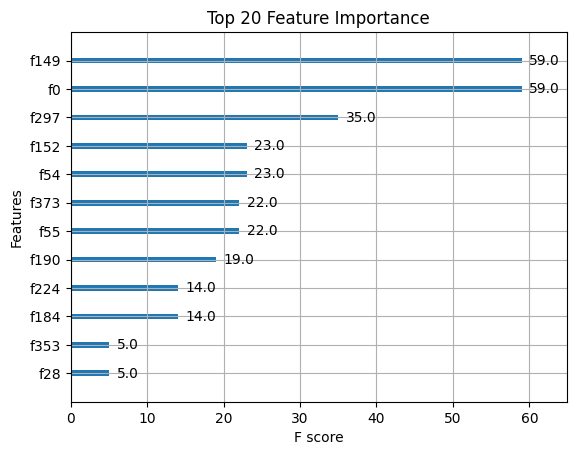

In [246]:
from xgboost import plot_importance

# Plot the top 20 features by importance
plot_importance(best_model, importance_type='weight', max_num_features=20)
plt.title('Top 20 Feature Importance')
plt.show()

In [249]:
# Save model
import joblib

# Save the best model to a file
joblib.dump(best_model, 'xgb_best_model.pkl')
print("Model saved as 'xgb_best_model.pkl'")


Model saved as 'xgb_best_model.pkl'


# Model Prediction

In [253]:
# Predicting likes for new content
new_content = """
Hey there future business leaders! 🌟 Ready to take your career to the next level with NYU's Master's program in Business? 💼
📈 Get ready to dive deep into cutting-edge strategies, network with industry experts, and gain the skills you need to succeed in
today's fast-paced business world. 🚀 Don't just dream about success – make it happen at NYU! Apply now and join our
community of driven, ambitious professionals. Let's do this! 💪 #NYUBusinessMasters #FutureLeaders #SuccessStartsHere 🎓
🔥
"""

# Preprocess the new content
def preprocess(text):
    # Example preprocessing steps
    text = text.lower()
    # Add more steps as needed
    return text

new_content_processed = preprocess(new_content)

# Encode the new content
new_embedding = model.encode([new_content_processed])  # Shape: (1, 384)

# Predict using the trained model
predicted_likes = best_model.predict(new_embedding)

print(f"\nPredicted number of likes for the new content: {predicted_likes[0]:.0f}")



Predicted number of likes for the new content: 60


In [254]:
# Predicting likes for new content
new_content = """
Hey there, future business leaders! 🌟 Ready to take your career to the next level with NYU's Master's program in Business?
Get ready to dive into cutting-edge coursework, collaborate with top industry professionals, and network like never before. Our
program is designed to challenge you, inspire you, and push you to reach your full potential. So what are you waiting for? Apply
now and get ready to #NYUBusinessYourFuture! 💼🎓 #GradSchoolGoals #BusinessMasters #NYU2022
"""

# Preprocess the new content
def preprocess(text):
    # Example preprocessing steps
    text = text.lower()
    # Add more steps as needed
    return text

new_content_processed = preprocess(new_content)

# Encode the new content
new_embedding = model.encode([new_content_processed])  # Shape: (1, 384)

# Predict using the trained model
predicted_likes = best_model.predict(new_embedding)

print(f"\nPredicted number of likes for the new content: {predicted_likes[0]:.0f}")


Predicted number of likes for the new content: 57


In [255]:
# Predicting likes for new content
new_content = """
The intersection of technology and business has always been a hot topic, but the rise of artificial intelligence (AI) is taking it to a
whole new level. AI is transforming industries across the board, from healthcare to finance to retail. But what does this mean for
business leaders? How can they harness the power of AI to drive growth and innovation in their organizations? These are just
some of the questions we'll be exploring in our upcoming webinar on ""AI and Business: Navigating the Future."" Join us as we
dive into the latest research and insights on how AI is reshaping the business landscape, and learn how you can leverage this
powerful technology to stay ahead of the curve. Don't miss out on this opportunity to gain valuable knowledge and network with
industry experts. Register now for our free webinar on AI and Business! #AI #business #innovation
"""

# Preprocess the new content
def preprocess(text):
    # Example preprocessing steps
    text = text.lower()
    # Add more steps as needed
    return text

new_content_processed = preprocess(new_content)

# Encode the new content
new_embedding = model.encode([new_content_processed])  # Shape: (1, 384)

# Predict using the trained model
predicted_likes = best_model.predict(new_embedding)

print(f"\nPredicted number of likes for the new content: {predicted_likes[0]:.0f}")


Predicted number of likes for the new content: 57
